## Wines country of origin prediction

In this notebook, we will try to predict the country of origin of different wines based on their descriptions. This is meant to be an excercise for Lesson 5 of fast.ai Deep Learning course.

In [20]:
import pandas as pd
import nltk
import re
import os
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Embedding, Convolution1D, MaxPooling1D, LSTM, GRU, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

## Data preprocessing

The dataset was obtained from Wine Reviews dataset published on Kaggle (https://www.kaggle.com/zynicide/wine-reviews). It was downloaded and extracted to a `data` folder.

In [2]:
df = pd.read_csv('data/winemag-data_first150k.csv')

In [3]:
df.country.value_counts()

US                        62397
Italy                     23478
France                    21098
Spain                      8268
Chile                      5816
Argentina                  5631
Portugal                   5322
Australia                  4957
New Zealand                3320
Austria                    3057
Germany                    2452
South Africa               2258
Greece                      884
Israel                      630
Hungary                     231
Canada                      196
Romania                     139
Slovenia                     94
Uruguay                      92
Croatia                      89
Bulgaria                     77
Moldova                      71
Mexico                       63
Turkey                       52
Georgia                      43
Lebanon                      37
Cyprus                       31
Brazil                       25
Macedonia                    16
Serbia                       14
Morocco                      12
Luxembou

Since there are way too many different countries of origin, we will focus on the predictions for the top 10 most common wines of the dataset.

In [4]:
top10_wines = df.country.value_counts()[:10].index

In [5]:
df_top10 = df[df.country.isin(top10_wines)]

In [6]:
len(df_top10)

143344

In [7]:
df_top10.country.value_counts()

US             62397
Italy          23478
France         21098
Spain           8268
Chile           5816
Argentina       5631
Portugal        5322
Australia       4957
New Zealand     3320
Austria         3057
Name: country, dtype: int64

Since we want to create embeddings for each of the words in the description, we will use the GloVe pre-trained word vectors from Stanford NLP Group (https://nlp.stanford.edu/projects/glove/). 

In [8]:
def clean(s):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric

    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()

def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]

def get_glove():
    if os.path.isfile('data/glove.pickle'):
        with open('data/glove.pickle', 'rb') as handle:
            return pickle.load(handle)
    else:
        if os.path.isfile('data/glove.6B.100d.txt'):
            glove_dict = {}
            with open('data/glove.6B.100d.txt') as f:
                i=0
                for a in f:
                    glove_dict[a.split()[0]] = i
                    i = i+1
            with open('data/glove.pickle', 'wb') as handle:
                pickle.dump(glove_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
            return glove_dict
        
def get_glove_matrix():
    X = []
    if os.path.isfile('data/glove.6B.100d.txt'):
        with open('data/glove.6B.100d.txt') as f:
            for a in f:
                X.append(np.fromstring((" ".join(a.split()[1:])), dtype=float, sep=' '))
    return np.array(X)

def transform_text(w2vmodel, words, maxlen=20):
    data = list()
    for i in range(0, maxlen):  #range(0, len(words)-1):
        if i < len(words):
            word = words[i]
            if word in w2vmodel:
                index = w2vmodel[word]
            else:
                index = w2vmodel["unk"]
        else:
            index = w2vmodel["unk"]
        data.append(index)
    return np.asarray(data)

In [9]:
glove_dict = get_glove()

In [10]:
glove_dict_inv = dict((v,k) for k,v in glove_dict.iteritems())

And once the pretrained embeddings are loaded, we transform our descriptions into a arrays of GloVe indices. These were limited to 50 words per description based on the distribution of descriptions lengths.

In [11]:
X = []
for desc in df_top10.description:
    desc_proc = clean(desc.decode("ascii", errors="ignore").encode()).split()
    desc_emb = transform_text(glove_dict,desc_proc,50)
    X.append(desc_emb)
X = np.array(X)

In [12]:
X.shape

(143344L, 50L)

Onehot encoding the labels to fit the output of the neural network that we wil train.

In [13]:
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
enc.fit(df_top10['country'])
new_cat_features = enc.transform(df_top10['country'])
new_cat_features = new_cat_features.reshape(-1, 1) # Needs to be the correct shape
ohe = preprocessing.OneHotEncoder(sparse=False) #Easier to read
labels = ohe.fit_transform(new_cat_features)

In [14]:
msk = np.random.rand(len(X)) < 0.8
trn = X[msk]
val = X[~msk]
trn_labels = labels[msk]
val_labels = labels[~msk]

In [15]:
val_labels.shape

(28742L, 10L)

In [16]:
val.shape

(28742L, 50L)

In [17]:
glove_matrix = get_glove_matrix()

In [ ]:
glove_matrix.shape

# CNN

Firstly, we will try an approach based on a CNN with 1D convolutions of size 5 follow by a fully connected layer.

In [ ]:
model = Sequential([
    Embedding(400000, 100, input_length=50, dropout=0.2, 
              weights=[glove_matrix], trainable=False),
    Dropout(0.25),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    Dropout(0.25),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(10, activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=2, batch_size=64)

In [ ]:
model.layers[0].trainable=True

In [ ]:
model.optimizer.lr=1e-4

In [ ]:
model.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=10, batch_size=64)

# LSTM

Second, we will try a simple RNN based on LSTM.

In [ ]:
model = Sequential([
    Embedding(400000, 100, input_length=50, mask_zero=True,
              weights=[glove_matrix], W_regularizer=l2(1e-6), dropout=0.2),
    LSTM(100, consume_less='gpu'),
    Dense(10, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=10, batch_size=64)

In [ ]:
model.save_weights('data/lstm.h5')

In [ ]:
model.load_weights('data/lstm.h5')

# GRU

In [21]:
model = Sequential([
    Embedding(400000, 100, input_length=50, weights=[glove_matrix], W_regularizer=l2(1e-6), dropout=0.2),
    BatchNormalization(),
    LSTM(100, consume_less='gpu'),
    Dropout(0.2),
    Dense(10, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=10, batch_size=64)

Train on 114602 samples, validate on 28742 samples
Epoch 1/10
114602/114602 [==============================] - 326s - loss: 2.0933 - acc: 0.6925 - val_loss: 0.7442 - val_acc: 0.7804
Epoch 2/10
114602/114602 [==============================] - 335s - loss: 0.7101 - acc: 0.7842 - val_loss: 0.6114 - val_acc: 0.8153
Epoch 3/10
114602/114602 [==============================] - 330s - loss: 0.5869 - acc: 0.8219 - val_loss: 0.5278 - val_acc: 0.8464
Epoch 4/10
114602/114602 [==============================] - 329s - loss: 0.5024 - acc: 0.8521 - val_loss: 0.4629 - val_acc: 0.8653
Epoch 5/10
114602/114602 [==============================] - 324s - loss: 0.4457 - acc: 0.8718 - val_loss: 0.4460 - val_acc: 0.8742
Epoch 6/10
114602/114602 [==============================] - 326s - loss: 0.4037 - acc: 0.8859 - val_loss: 0.4431 - val_acc: 0.8720
Epoch 7/10
114602/114602 [==============================] - 324s - loss: 0.3735 - acc: 0.8955 - val_loss: 0.4099 - val_acc: 0.8849
Epoch 8/10
114602/114602 [======

# Result analysis

The 0.9 accuracy obtained in the validation set by the RNN seems to be fairly good considering the amount of classes present and the size of the descriptions. Let's have a look at the confusion matrix to see what went on during the predictions.

In [23]:
predictions = model.predict_classes(val)
prediction_prob = model.predict(val)

28742/28742 [==============================] - 14s    


In [24]:
real_val = [np.argmax(i) for i in val_labels]

## Confusion matrix

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  738     1     0   194     3     7     0     0   139    19]
 [    0   849     0     4    44    20    37     1     3    73]
 [    1     6   391     1   171     4     3    20     0    14]
 [  122    14     1   845     6    16     4     1   101    47]
 [    1    62    56     2  3786    15    16   143    10    90]
 [   14    15     1    17    20  4508     2     0    39    59]
 [    0    48     1     4    15     2   586     0     0    42]
 [    0    17    10     0   386     2     1   661     0    11]
 [  137     2     0   210     4    15     0     1  1296    18]
 [    0    74    13    21    87    61    26     4     6 12225]]


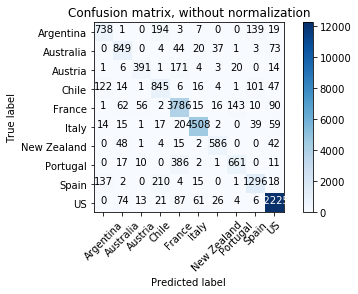

In [26]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(real_val, predictions)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=enc.classes_,
                      title='Confusion matrix, without normalization')
plt.show()

Seems like the model is confusing some wines coming from Argentina, Chile and Spain and also between France and Portugal. In the first case, it could be due to some spanish words showing up in the descriptions and, in the second case, the reason is not really clear.

## Errors

In [27]:
spanish_as_argentinian = [[x,z] for w,x,y,z in zip(predictions,prediction_prob,real_val,val) if w==0 and y==8]

In [28]:
s_a_s_sorted = sorted(spanish_as_argentinian, key=lambda x: x[0][0], reverse=True)

In [29]:
" ".join([glove_dict_inv[x] for x in s_a_s_sorted[0][1]])

'tropical on the nose with lychee fruit and tangerine aromas the palate is easygoing and fairly thorough while the flavor profile suggest argentine unk as it deals lychee powdered sugar and papaya clean light quaffable and that s about it unk unk unk unk unk unk unk unk unk unk'

In [30]:
spanish_as_chilean = [[x,z] for w,x,y,z in zip(predictions,prediction_prob,real_val,val) if w==4 and y==8]

In [31]:
s_a_c_sorted = sorted(spanish_as_chilean, key=lambda x: x[0][0], reverse=True)

In [32]:
" ".join([glove_dict_inv[x] for x in s_a_c_sorted[0][1]])

'this medium sweet wine has a lot of issues first off it smells like cooked bananas next the palate is like mango cotton candy third the juice itself will take a coat of enamel off your teeth need more imported by vineyard brands unk unk unk unk unk unk unk'